# **Market Analysis &ndash; Part 2**

This Notebook performs the computations and visualizations for the second part of the market analysis (sentiment analysis) of our paper:

* Sentiment analysis using SiEBERT
* Bar chart for sentiment analysis

Note that this Notebook has been run in Kaggle and some code, such as the loading of the data, will have to be changed if you run this Notebook outside of Kaggle.

## Preparation

In [1]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, set_seed

# Set random seeds for reproducible and consistent results
set_seed(42)

## Sentiment analysis

In [2]:
# Define SentimentDataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=self.max_length)
        return inputs

In [3]:
# Define the sentiment analysis function
def run_sentiment_analysis(input_path, output_path, text_column):
    # Define the parameters
    model_id='siebert/sentiment-roberta-large-english'
    batch_size=32

    # Load the data
    df = pd.read_csv(input_path)

    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id)

    # Move the model to the GPU (or CPU if no GPU available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval() # Set model to evaluation mode

    # Prepare the dataset and dataloader
    texts = df[text_column].to_list()
    dataset = SentimentDataset(texts, tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Store predictions
    predictions = []

    # Perform sentiment classification
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Classifying"):
            # Move inputs to GPU/CPU
            inputs = {key: val.squeeze(1).to(device) for key, val in batch.items()}
            outputs = model(**inputs)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=1).tolist()
            predictions.extend(batch_predictions)

    # Add predictions to DataFrame
    df['label'] = predictions

    # Save the results to a parquet file
    df.to_csv(output_path, index=False)

    print(f"Sentiment analysis complete for {input_path}. Results saved to {output_path}.")

In [4]:
# Classify real reviews
run_sentiment_analysis(
    input_path='/kaggle/input/real-reviews-sample/real_reviews_10k_sample.csv',
    output_path='real_reviews_10k_sample_sentiment.csv',
    text_column='text'
)

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Classifying: 100%|██████████| 313/313 [09:19<00:00,  1.79s/it]

Sentiment analysis complete for /kaggle/input/real-reviews-sample/real_reviews_10k_sample.csv. Results saved to real_reviews_10k_sample_sentiment.csv.


In [5]:
# Classify GPT-2 reviews
run_sentiment_analysis(
    input_path='/kaggle/input/gpt-2-reviews/gpt-2_synthetic_reviews.csv',
    output_path='gpt-2_synthetic_reviews_sentiment.csv',
    text_column='Generated Review'
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Classifying: 100%|██████████| 313/313 [09:20<00:00,  1.79s/it]


Sentiment analysis complete for /kaggle/input/gpt-2-reviews/gpt-2_synthetic_reviews.csv. Results saved to gpt-2_synthetic_reviews_sentiment.csv.


In [6]:
# Classify LLaMA 3 reviews
run_sentiment_analysis(
    input_path='/kaggle/input/llama-3-reviews/llama-3_synthetic_reviews_split.csv',
    output_path='llama-3_synthetic_reviews_split_sentiment.csv',
    text_column='Generated Review'
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Classifying: 100%|██████████| 313/313 [09:19<00:00,  1.79s/it]


Sentiment analysis complete for /kaggle/input/llama-3-reviews/llama-3_synthetic_reviews_split.csv. Results saved to llama-3_synthetic_reviews_split_sentiment.csv.


## Bar chart for sentiment analysis

In [7]:
# Load the data with the sentiment labels
real_reviews_sentiments = pd.read_csv('/kaggle/working/real_reviews_10k_sample_sentiment.csv')
gpt2_reviews_sentiments = pd.read_csv('/kaggle/working/gpt-2_synthetic_reviews_sentiment.csv')
llama3_reviews_sentiments = pd.read_csv('/kaggle/working/llama-3_synthetic_reviews_split_sentiment.csv')

In [8]:
# Prepare the data for visualization
## Convert Series to DataFrame and add the 'review_type' column
real_reviews_sentiments = pd.DataFrame(real_reviews_sentiments, columns=['label'])
real_reviews_sentiments['review_type'] = 'Real Reviews'

gpt2_reviews_sentiments = pd.DataFrame(gpt2_reviews_sentiments, columns=['label'])
gpt2_reviews_sentiments['review_type'] = 'GPT-2 Reviews'

llama3_reviews_sentiments = pd.DataFrame(llama3_reviews_sentiments, columns=['label'])
llama3_reviews_sentiments['review_type'] = 'LLaMA 3 Reviews'

## Combine all datasets into one DataFrame
combined_data = pd.concat([real_reviews_sentiments, gpt2_reviews_sentiments, llama3_reviews_sentiments])

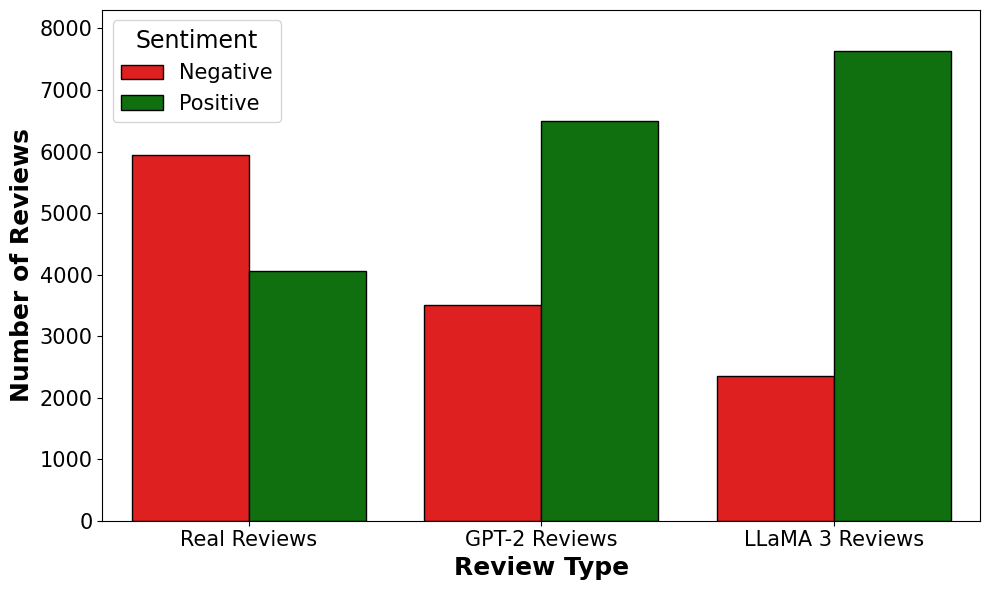

In [9]:
# Extract number of reviews by sentiment
value_counts = combined_data.groupby(['review_type', 'label']).size().reset_index(name='counts')

# Plot number of reviews by ratings and sentiment
fig, ax = plt.subplots(figsize=(10, 6))

# Create the seaborn barplot
sns_barplot = sns.barplot(
    data=value_counts,
    x='review_type',
    y='counts',
    hue='label', 
    palette={0: 'red', 1: 'green'},
    ax=ax,
    order=['Real Reviews', 'GPT-2 Reviews', 'LLaMA 3 Reviews'],
    hue_order=[0,1]
)

# Customize bar appearance
for bar in sns_barplot.patches:
    bar.set_edgecolor('black')  # Set the border color
    bar.set_linewidth(1)        # Set the border thickness

# Set x and y axis labels
ax.set_xlabel('Review Type', weight='bold', fontsize=18)
ax.set_ylabel('Number of Reviews', weight='bold', fontsize=18)

# Set tick font sizes using tick_params
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

# Set the y axis limit
plt.ylim(top=8300)

# Add custom legend
ax.legend_.remove()
handles, labels = ax.get_legend_handles_labels()
custom_labels = ['Negative', 'Positive']
plt.legend(title='Sentiment', handles=handles, labels=custom_labels, title_fontsize=17, fontsize=15)

# Save and show the plot
plt.savefig('sentiment_distribution_review_types.pdf', format='pdf', dpi=1500)
plt.tight_layout()
plt.show()

In [10]:
# Calculate the ratio of negative to positive
value_counts_perc = value_counts.copy()
value_counts_perc['percentage'] = value_counts_perc['counts'] / 10000
value_counts_perc

,review_type,label,counts,percentage
0,GPT-2 Reviews,0,3506,0.3506
1,GPT-2 Reviews,1,6494,0.6494
2,LLaMA 3 Reviews,0,2360,0.2360
3,LLaMA 3 Reviews,1,7640,0.7640
4,Real Reviews,0,5945,0.5945
5,Real Reviews,1,4055,0.4055
